## Organ differences by Milo - myeloid

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
import scvelo as scv

In [4]:
import milopy.core as milo
import milopy.plot as milopl

In [5]:
## import project utils
cwd = '../utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

In [6]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/organ_milo_analysis_MYELOID/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir

In [7]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [8]:
%load_ext rpy2.ipython


In [9]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [10]:
import milopy

def annotate_nhoods(adata, anno_col):
    anno_dummies = pd.get_dummies(adata.obs[anno_col])
    anno_count = adata.obsm["nhoods"].T.dot(scipy.sparse.csr_matrix(anno_dummies.values))
    anno_frac = np.array(anno_count/anno_count.sum(1))

    anno_frac = pd.DataFrame(anno_frac, 
                             columns=anno_dummies.columns,
                             index=adata.uns["nhood_adata"].obs_names
                            )
    adata.uns["nhood_adata"].obsm["frac_annotation"] = anno_frac.values
    adata.uns["nhood_adata"].uns["annotation_labels"] = anno_frac.columns
    adata.uns["nhood_adata"].obs["nhood_annotation"] = anno_frac.idxmax(1)
    adata.uns["nhood_adata"].obs["nhood_annotation_frac"] = anno_frac.max(1)

## Load milo neighbourhoods
Computed in `src/7_differential_abundance`

In [11]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="MYELOID_V2"

In [10]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_outs/{s}/'.format(s=split)
adata = sc.read_h5ad(outdir + "adata4milo.{s}.h5ad".format(s=split))

In [11]:
nhood_adata = sc.read_h5ad(outdir + "milo_nhood_adata.{s}.h5ad".format(s=split))

adata.uns["nhood_adata"] = nhood_adata.copy()

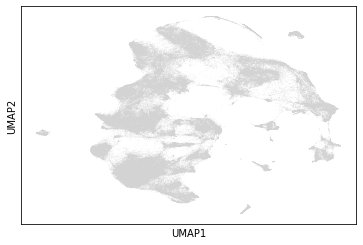

In [13]:
sc.pl.umap(adata)

### Make neighbourhoods
Larger neighbourhoods than for analysis in time (more samples per condition)

In [14]:
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 100, key_added="scvi")

## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.05)

## Count cells in neighbourhoods
milo.count_nhoods(adata, sample_col="Sample.lanes")

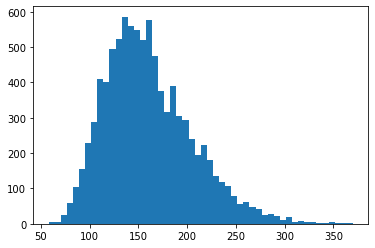

In [15]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=50);

### Test for enrichment of an organ

In [15]:
# def _milo_test_organ_abundance(adata, org, design = '~ method + correction_factor + test_organ'):
#     adata.obs['test_organ'] = adata.obs.organ==org
#     adata.obs['test_organ'] = adata.obs['test_organ'].astype("str").astype("category")
#     milopy.utils.add_covariate_to_nhoods_var(adata, ['test_organ'])
#     milo.DA_nhoods(adata, design=design)

# milopy.utils.add_covariate_to_nhoods_var(adata, ['method', 'Sort_id', 'donor'])
# all_organs = adata.obs.organ.unique().tolist()
# design = '~ method + correction_factor + test_organ'

# ## Calculate logFC and SpatialFDR within each organ
# milo_res_dict = {}
# for org in all_organs:
#     print(org)
#     _milo_test_organ_abundance(adata, org, design)
#     milo_res_dict[org] = adata.uns["nhood_adata"].obs.copy()

SK
SP
YS
LI
TH
GU
BM
KI


In [113]:
import milopy.core as milo
import milopy.plot as milopl

In [ ]:
adata.obs['organ'] = adata.obs['organ'].astype("category")
milopy.utils.add_covariate_to_nhoods_var(adata, ['method', 'Sort_id', 'donor', 'organ'])
adata.uns['nhood_adata'].var['organ'] = adata.uns['nhood_adata'].var['organ'].astype('category')
all_organs = adata.obs.organ.unique().tolist()
design = '~ method + correction_factor + organ'

## Calculate logFC and SpatialFDR within each organ
milo_res_dict = {}
for org in all_organs:
    print(org)
    if org == adata.uns['nhood_adata'].var.organ.cat.categories[0]:
        nhood_adata = adata.uns['nhood_adata'].copy()
        new_cats = nhood_adata.var.organ.cat.categories[1:].tolist()
        new_cats.append(org)
        nhood_adata.var.organ.cat.reorder_categories(new_cats, inplace=True)
        adata.obs.organ.cat.reorder_categories(new_cats, inplace=True)
        adata.uns['nhood_adata'] = nhood_adata.copy()
#     _milo_test_organ_abundance(adata, org, design)
    milo.DA_nhoods(adata, design=design, model_contrasts='organ{o}'.format(o=org))
    milo_res_dict[org] = adata.uns["nhood_adata"].obs.copy()

In [157]:
## Collapse results
logFC_df_ls = [v["logFC"] for k,v in milo_res_dict.items()]
for k,v in milo_res_dict.items():
    milo_res_dict[k]["logFC_" + k] = milo_res_dict[k]["logFC"].copy()
    milo_res_dict[k]["SpatialFDR_" + k] = milo_res_dict[k]["SpatialFDR"].copy()

org_fc = pd.concat([v[["logFC_" + k]] for k,v in milo_res_dict.items()], 1)
org_fdr = pd.concat([v[["SpatialFDR_" + k]] for k,v in milo_res_dict.items()], 1)

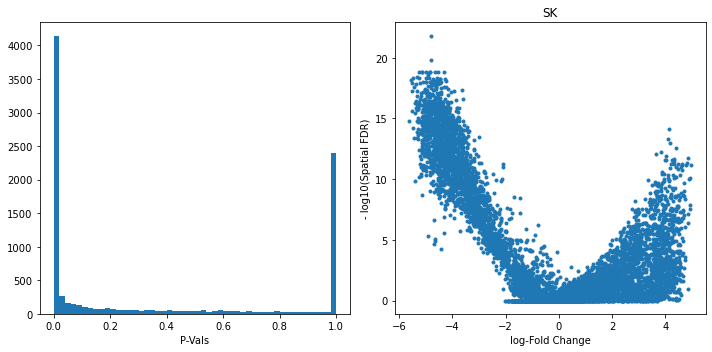

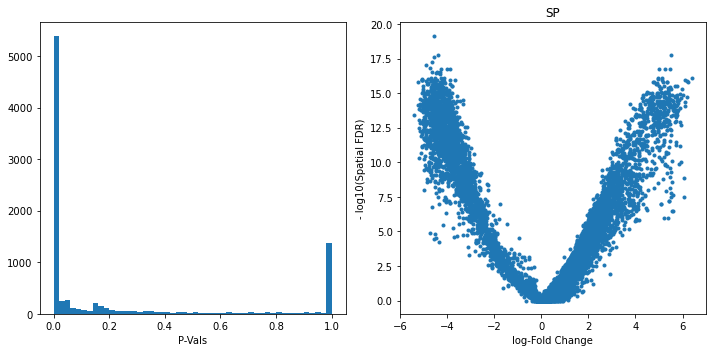

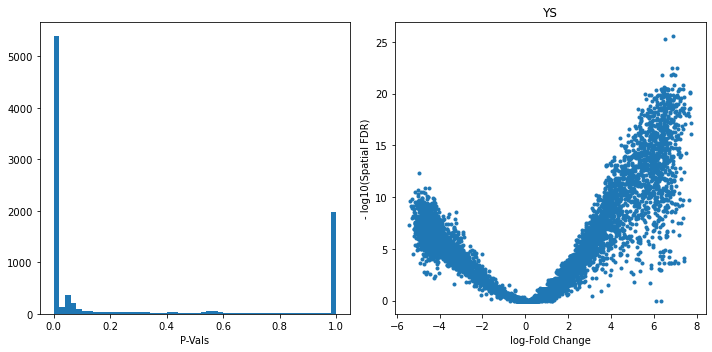

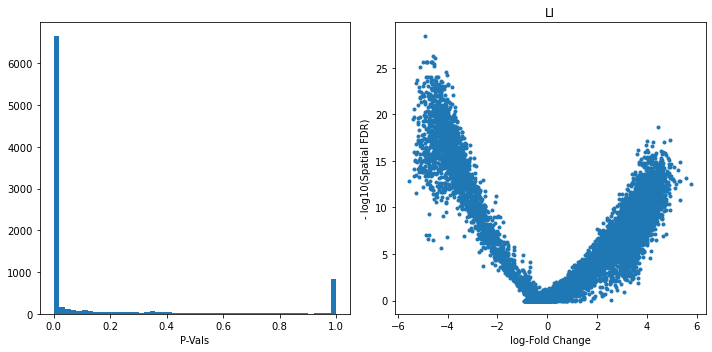

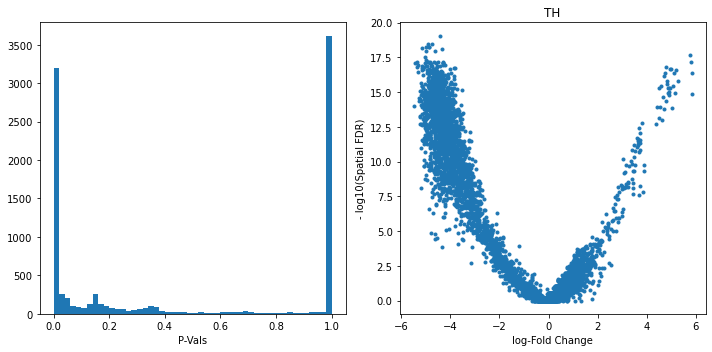

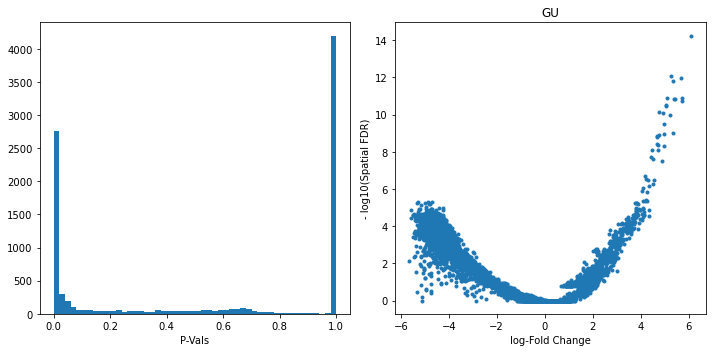

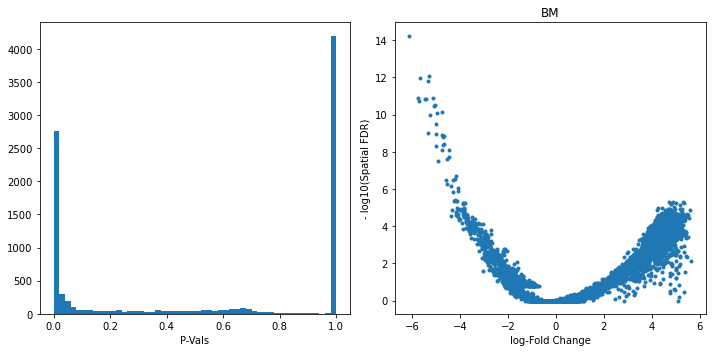

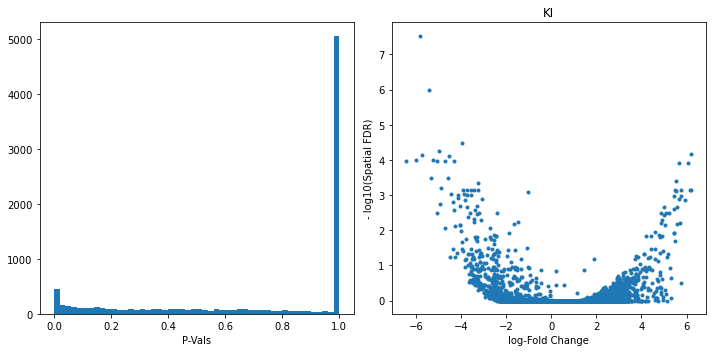

In [158]:
old_figsize = plt.rcParams["figure.figsize"]
for org, milo_res in milo_res_dict.items():
    plt.rcParams["figure.figsize"] = [10,5]
    plt.subplot(1,2,1)
    plt.hist(milo_res.PValue, bins=50);
    plt.xlabel("P-Vals");
    plt.subplot(1,2,2)
    plt.plot(milo_res.logFC, -np.log10(milo_res.SpatialFDR), '.');
    plt.xlabel("log-Fold Change");
    plt.ylabel("- log10(Spatial FDR)");
    plt.title(org);
    plt.tight_layout();
    plt.show()

plt.rcParams["figure.figsize"] = old_figsize

### Plot graph embeddings

In [159]:
milopy.utils.build_nhood_graph(adata)

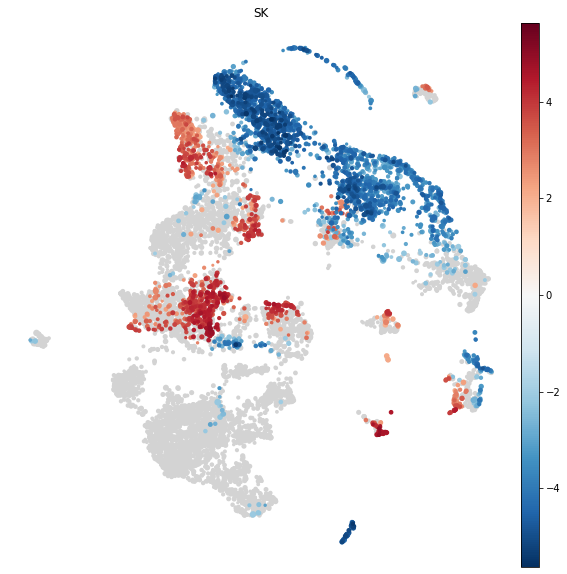

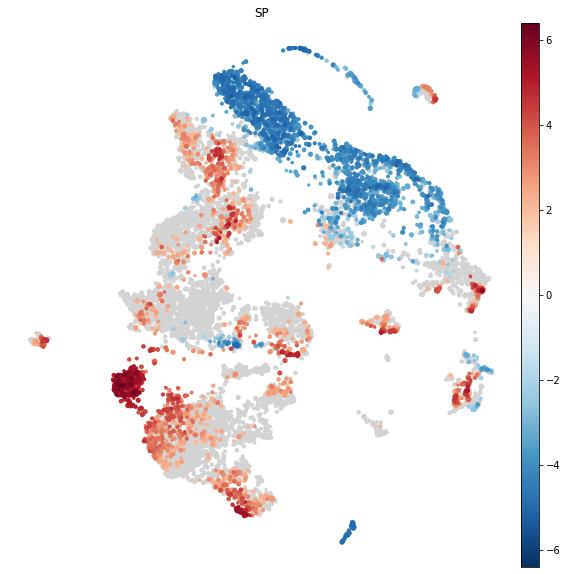

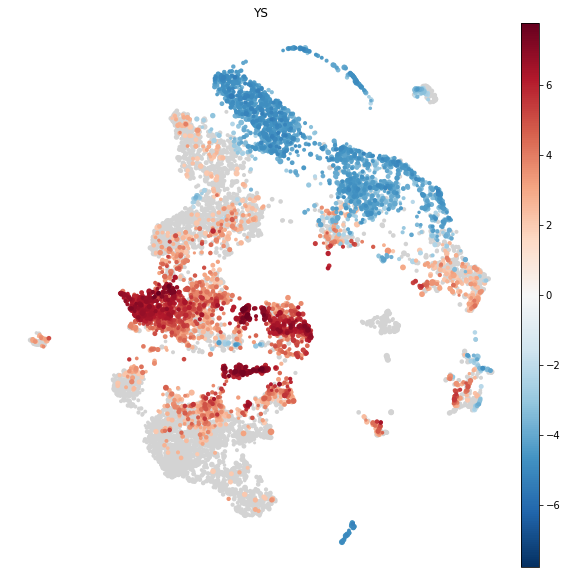

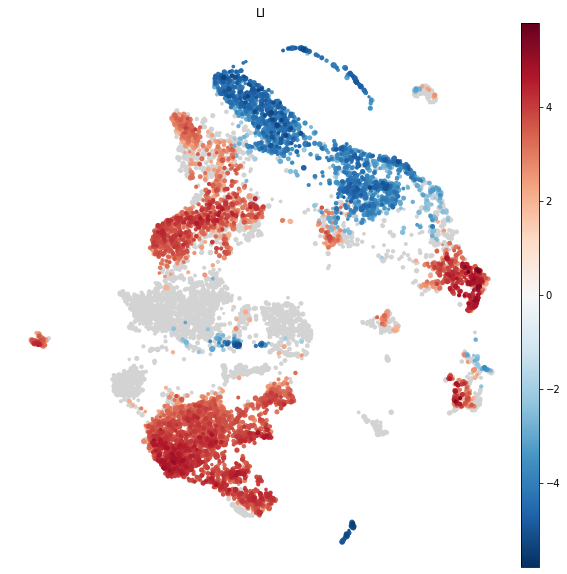

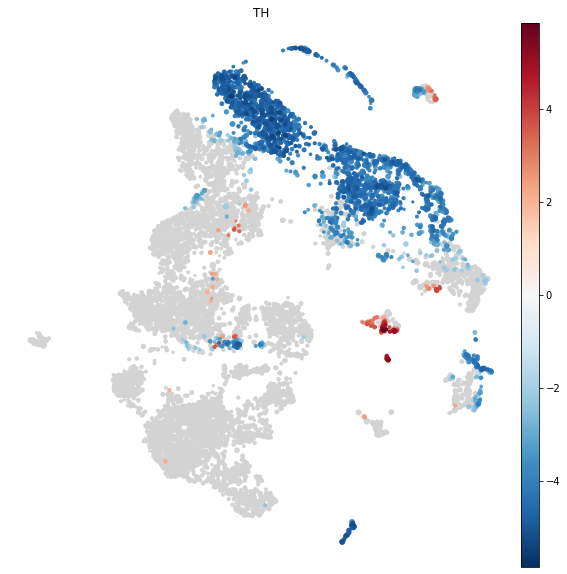

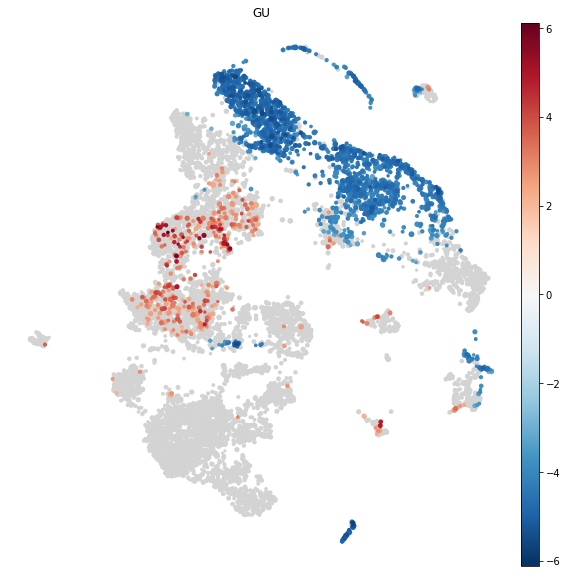

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


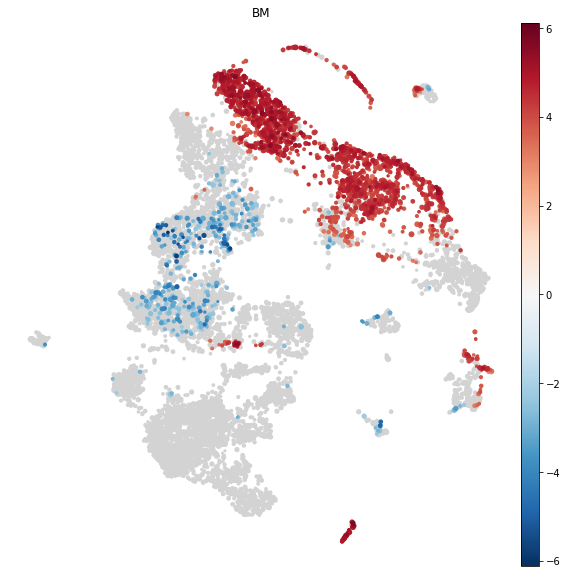

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


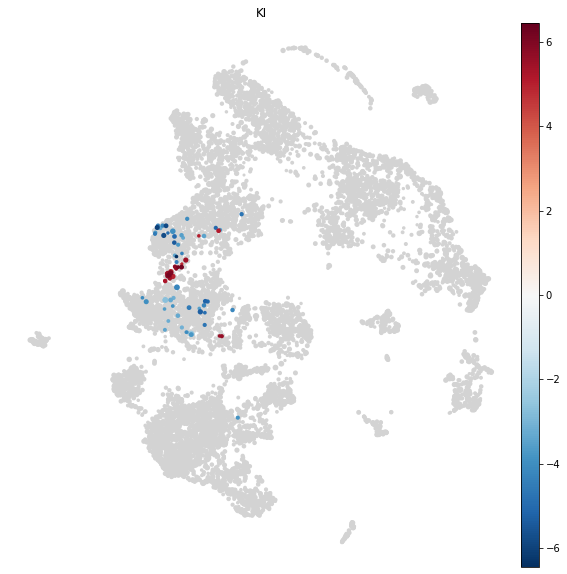

In [186]:
plt.rcParams["figure.figsize"] = [10,10]
milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    milopl.plot_nhood_graph(adata, alpha=0.01, 
                            min_logFC= 2, min_size=0.5, title=org)

In [16]:
alpha = 0.01
min_logFC = 2
min_size=0.5
plot_edges = False

In [254]:
def plot_nhood_graph_enrichment(nhood_adata, alpha = 0.01,
    min_logFC = 2,
    min_size=0.5,
    plot_edges = False,
    title='ciao',**kwargs):
#     nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = nhood_adata.obs["logFC"]
    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan
    nhood_adata.obs["abs_logFC"] = abs(nhood_adata.obs["logFC"])
    nhood_adata.obs.loc[nhood_adata.obs["abs_logFC"] < min_logFC, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] < 0, "graph_color"] = np.nan

    ## Plotting order - extreme logFC on top
    nhood_adata.obs.loc[nhood_adata.obs["graph_color"].isna(), "abs_logFC"] = np.nan
    ordered = nhood_adata.obs.sort_values('abs_logFC', na_position='first').index
    nhood_adata = nhood_adata[ordered]

#     vmax = np.max([nhood_adata.obs["graph_color"].max(), abs(nhood_adata.obs["graph_color"].min())])
    vmin = 0

    sc.pl.embedding(nhood_adata, "X_milo_graph", 
                    color="graph_color", cmap="Reds",
                    size=nhood_adata.obs["Nhood_size"]*min_size, 
                    edges=plot_edges, neighbors_key="nhood",
                    # edge_width = 
                    sort_order=False,
                    frameon=False,
#                     vmax=vmax, 
                    vmin=vmin,
                    title=title,
                    **kwargs
                   )

In [260]:
plt.rcParams["figure.figsize"] = [7,7]
sns.set_context("talk")
sc.pl.embedding(nhood_adata, "X_milo_graph", 
                color="nhood_annotation",
                size=nhood_adata.obs["Nhood_size"]*min_size, 
                edges=plot_edges, neighbors_key="nhood",
                # edge_width = 
                sort_order=False,
                frameon=False,
#                     vmax=vmax, 
                vmin=vmin,
                title='',
                legend_loc="on data",
                save='nhood_graph_mono_anno.pdf'
               )


# milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
    nhood_adata = adata.uns["nhood_adata"][adata.uns["nhood_adata"].obs['nhood_annotation'].isin(anno_group_myeloid['Mono'])].copy()
    plot_nhood_graph_enrichment(nhood_adata, alpha=0.01, min_logFC= 2, min_size=0.5, title=org, 
                                save='nhood_graph_mono_{o}.pdf'.format(o=org))

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


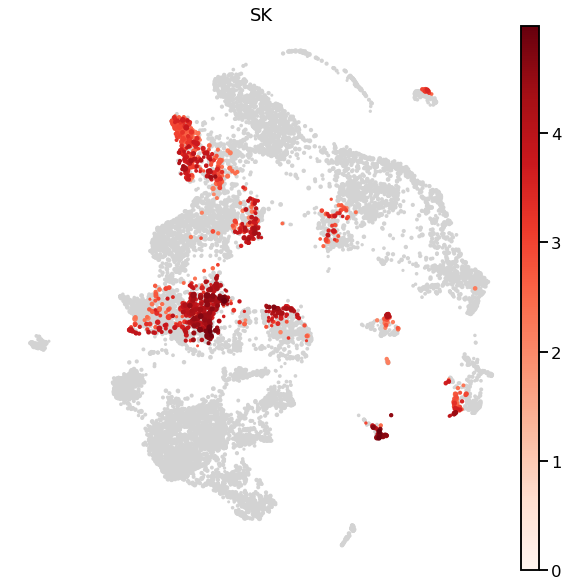

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


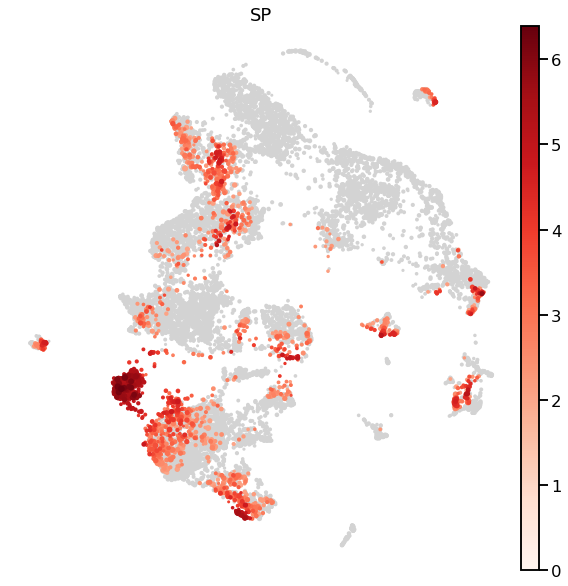

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


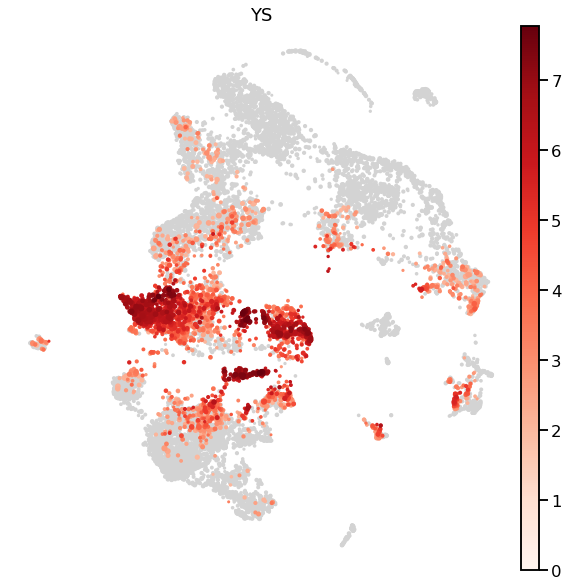

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


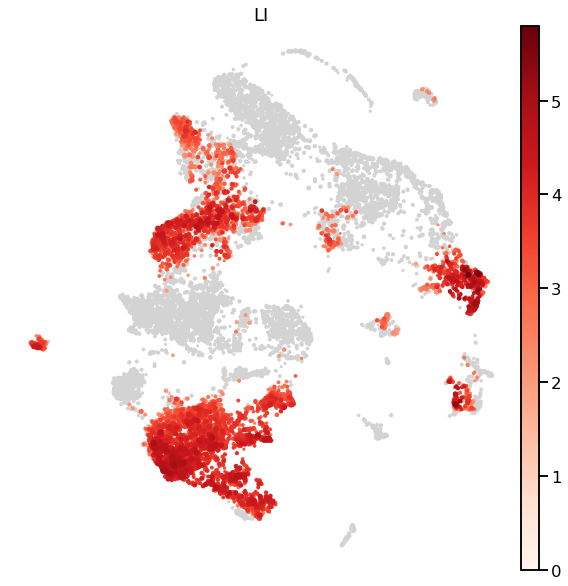

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


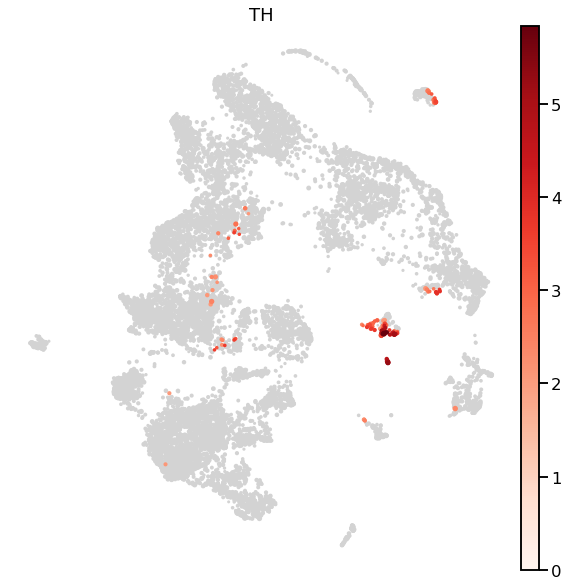

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


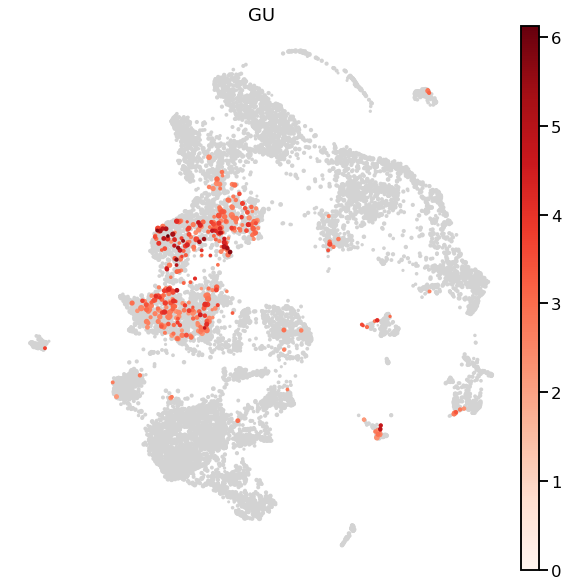

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


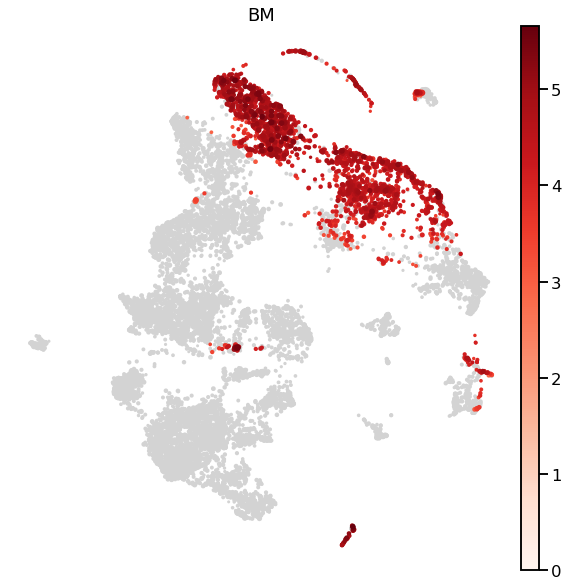

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


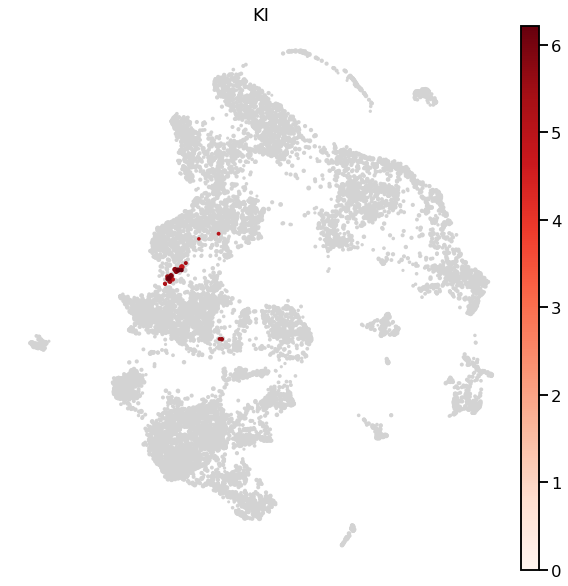

In [263]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")

# milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
    nhood_adata = adata.uns["nhood_adata"].copy()
    plot_nhood_graph_enrichment(nhood_adata, alpha=0.01, min_logFC= 2, min_size=0.5, title=org, 
                                save='nhood_graph_{o}.pdf'.format(o=org))

### Monocyte figure

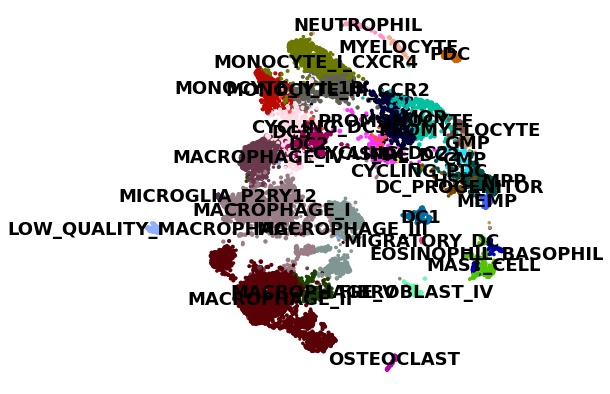

In [18]:
plt.rcParams["figure.figsize"] = [7,7]
sns.set_context("talk")
sc.pl.embedding(nhood_adata, "X_milo_graph", 
                color="nhood_annotation",
                size=nhood_adata.obs["Nhood_size"]*min_size, 
                edges=plot_edges, neighbors_key="nhood",
                # edge_width = 
                sort_order=False,
                frameon=False,
#                     vmax=vmax, 
                vmin=0,
                title='',
                legend_loc="on data",
                save='nhood_graph_mono_anno.pdf'
               )

In [260]:
# milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
    nhood_adata = adata.uns["nhood_adata"][adata.uns["nhood_adata"].obs['nhood_annotation'].isin(anno_group_myeloid['Mono'])].copy()
    plot_nhood_graph_enrichment(nhood_adata, alpha=0.01, min_logFC= 2, min_size=0.5, title=org, 
                                save='nhood_graph_mono_{o}.pdf'.format(o=org))

In [ ]:
nhood_adata.obs[['nhood_annotation_frac', "nhood_annotation"]]

### Visualize with beeswarm plot

In [161]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
    

In [162]:
org_fc_filtered = org_fc.copy()
org_fc_filtered.values[org_fdr.values > 0.1] = 0

In [163]:
## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

In [164]:
anno_group_myeloid = {
    "MACs":[x for x in org_fc_filtered.nhood_anno.unique() if "ACROPHAGE" in x],
    'DCs':[x for x in org_fc_filtered.nhood_anno.unique() if "DC" in x],
    "Mono":[x for x in org_fc_filtered.nhood_anno.unique() if "MONO" in x],
    "Progenitors":anno_groups_dict["PROGENITORS"]
    }

anno_group_myeloid['other'] = [x for x in org_fc_filtered.nhood_anno.unique() if x not in sum(anno_group_myeloid.values(),[])]
anno_group_myeloid_rev = {x:g for g,a in anno_group_myeloid.items() for x in a}

In [165]:
org_fc_filtered['anno_group'] = [anno_group_myeloid_rev[x] for x in org_fc_filtered['nhood_anno']]

In [166]:
%%R -i org_fc_filtered -i org_fdr -h 1000 -w 800

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 
    
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ## Fix some names
    mutate(nhood_anno=ifelse(str_detect(nhood_anno, "NK$"), "NK", nhood_anno)) %>%
    ## Reorder by fold-change 
    group_by(organ, nhood_anno, Nhood) %>%
    mutate(mean_logFC = mean(logFC)) %>%
    ungroup() %>%
    group_by(organ, nhood_anno) %>%
    arrange(- mean_logFC) %>%
    ungroup()  %>%
    mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
    group_by(nhood_anno) %>%
    filter(length(unique(Nhood)) > 20) %>%
    ungroup()

head(plot_df)

Joining, by = c("Nhood", "organ")
  Nhood     nhood_anno anno_group organ    logFC   SpatialFDR mean_logFC
1    77 MACROPHAGE_III       MACs    YS 7.762319 7.867324e-17   7.762319
2  3460   MACROPHAGE_I       MACs    YS 7.729238 7.656428e-18   7.729238
3  2870   MACROPHAGE_I       MACs    YS 7.704757 9.467564e-21   7.704757
4  3435   MACROPHAGE_I       MACs    YS 7.698141 6.335116e-21   7.698141
5  2838   MACROPHAGE_I       MACs    YS 7.685297 2.691975e-19   7.685297
6    45 MACROPHAGE_III       MACs    YS 7.654682 1.771584e-10   7.654682


In [167]:
%%R -w 1200 -h 600 -i figdir -o pl_df
library(ggbeeswarm)
organ_colors_df <- read.csv("~/Pan_fetal_immune/metadata/organ_colors.csv")
organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)

anno_group_order <- c('Progenitors', 'DCs', 'Mono','MACs',  'low_confidence', 'other')

pl_df <- plot_df %>%
    mutate(logFC=ifelse(logFC > 0, logFC, 0)) %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% anno_group_order)

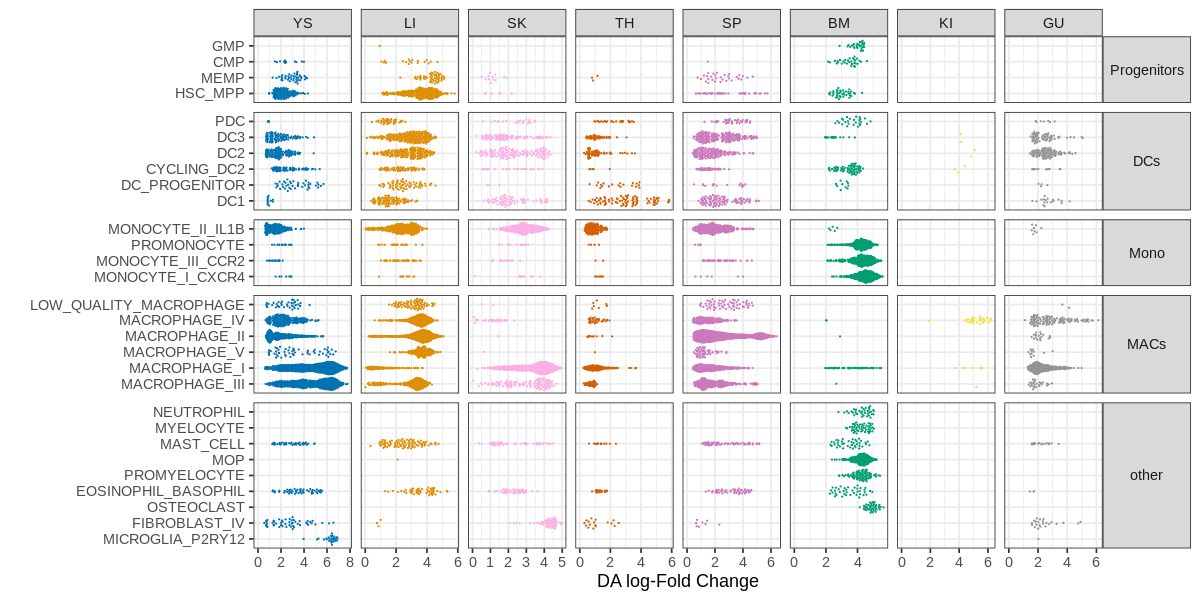

In [168]:
%%R -w 1200 -h 600
alpha=0.1
set.seed(12345)
pl1 <- 
    pl_df %>%
    mutate(organ_color=ifelse((SpatialFDR < alpha) & (logFC > 0), as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
#     geom_quasirandom(size=0.2, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.4, aes(color=organ_color)) +
#     geom_violin(data=. %>% filter(SpatialFDR < alpha), aes(color=organ_color)) +
#     geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
    theme_bw(base_size=18) +
    xlab("") + ylab("DA log-Fold Change") +
    theme(strip.text.y=element_text(angle=0))
    
pl1
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

### Visualize with heatmaps

In [224]:
min_lfc = 2
org_fc_filtered = org_fc.copy()
org_fc_filtered.values[org_fdr.values > 0.1] = 0
org_fc_filtered.values[org_fc_filtered.values < min_lfc] = 0

## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

## Add annotation grouping
anno_group_myeloid = {
    "MACs":[x for x in org_fc_filtered.nhood_anno.unique() if "ACROPHAGE" in x],
    'DCs':[x for x in org_fc_filtered.nhood_anno.unique() if "DC" in x],
    "Mono":[x for x in org_fc_filtered.nhood_anno.unique() if "MONO" in x],
    "Progenitors":anno_groups_dict["PROGENITORS"]
    }

anno_group_myeloid['other'] = [x for x in org_fc_filtered.nhood_anno.unique() if x not in sum(anno_group_myeloid.values(),[])]
anno_group_myeloid_rev = {x:g for g,a in anno_group_myeloid.items() for x in a}

org_fc_filtered['anno_group'] = [anno_group_myeloid_rev[x] for x in org_fc_filtered['nhood_anno']]

NameError: name 'org_fc' is not defined

In [170]:
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

org_fc_filtered["hclust_order"] = np.nan
for a in org_fc_filtered.nhood_anno.unique():
    ## Keep high FCs
    
    df = org_fc_filtered[org_fc_filtered.nhood_anno==a].drop(['nhood_anno', 'anno_group', 'hclust_order'], 1)
    clustering = ward(df.values)
    ordered_ixs = org_fc_filtered.index[org_fc_filtered.nhood_anno==a][leaves_list(clustering)]
    org_fc_filtered.loc[ordered_ixs, 'hclust_order'] = np.arange(sum(org_fc_filtered.nhood_anno==a))

In [171]:
anno_order = [
    ## Monocytes
    'PROMONOCYTE', 
    'MONOCYTE_I_CXCR4',
    'MONOCYTE_II_IL1B', 
    'MONOCYTE_III_CCR2',
    ## MA
]

In [172]:
%%R -i org_fc_filtered -w 1000 -h 500

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood, hclust_order), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 

In [173]:
%%R
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) 

plot_df %>%
arrange(-logFC) %>%
head()
 
    

Joining, by = c("Nhood", "organ")
  Nhood     nhood_anno anno_group hclust_order organ    logFC   SpatialFDR
1    77 MACROPHAGE_III       MACs          412    YS 7.762319 7.867324e-17
2  3460   MACROPHAGE_I       MACs          106    YS 7.729238 7.656428e-18
3  2870   MACROPHAGE_I       MACs          198    YS 7.704757 9.467564e-21
4  3435   MACROPHAGE_I       MACs           33    YS 7.698141 6.335116e-21
5  2838   MACROPHAGE_I       MACs          197    YS 7.685297 2.691975e-19
6    45 MACROPHAGE_III       MACs          411    YS 7.654682 1.771584e-10


In [174]:
%%R -w 1200 -h 500
library(ggrastr)
plot_organ_FC_hm_group <- function(plot_df, g, logFC_limits = c(0,7), layout_heights=c(1,4)){
    pl_df <- plot_df %>%
        arrange(nhood_anno, hclust_order) %>%
        mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
        mutate(organ=factor(organ, levels=rev(c("YS", "LI", "BM","TH", "SP", "MLN","SK", "KI", "GU")))) %>%
        mutate(logFC = pmin(logFC, logFC_limits[2])) %>%
        mutate(logFC = pmax(logFC, logFC_limits[1])) 

    p1 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,nhood_anno)) +
        geom_tile_rast(fill='black') +
        facet_grid(.~nhood_anno, scales='free', space="free") +
        theme_classic(base_size=18) +
        remove_x_axis() +
        ylab("") +
        theme(axis.line.x=element_blank(), strip.background=element_blank(), strip.text=element_blank()) +
        ggtitle(g)

    p2 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,organ,  fill=logFC)) +
        geom_tile_rast() +
        facet_grid(.~nhood_anno, scales='free', space="free") +
#       scale_fill_gradient(low='#f7f7f7', high='#b2182b', limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        scale_fill_distiller(palette='Oranges', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        theme_classic(base_size=18) +
        xlab("Neighbourhood") +
        theme(strip.background=element_blank(), strip.text=element_blank(), 
              axis.line.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank()) 

    (p1 / p2 ) + plot_layout(heights=layout_heights, guides='collect')
    } 
for (g in unique(plot_df$anno_group)){
    plot_organ_FC_hm_group(plot_df, g, layout_heights=c(1,1.5)) + 
    ggsave(paste0(figdir, "enrichment_hm_", g, '.pdf'), width=15, height=7) +
    ggsave(paste0(figdir, "enrichment_hm_", g, '.png'), width=15, height=7)
}

In [175]:
# %%R -w 1200 -h 1200
# pl_ls <- lapply(unique(plot_df$anno_group), function(g) plot_organ_FC_hm_group(plot_df, g, layout_heights=c(1,1.5)))
# wrap_plots(pl_ls[1:3], ncol=1) +
#     plot_layout(guides='collect')

In [176]:
%%R -h 1000 -w 800 -o plot_df
library(ggrastr)
plot_organ_FC_hm_group <- function(plot_df, g, logFC_limits = c(0,7)){

    pl_df <- plot_df %>%
        arrange(nhood_anno, hclust_order) %>%
        mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
        mutate(organ=factor(organ, levels=rev(c("YS", "LI", "BM","TH", "SP", "MLN","SK", "KI", "GU")))) %>%
        mutate(logFC = pmin(logFC, logFC_limits[2])) %>%
        mutate(logFC = pmax(logFC, logFC_limits[1])) 


    pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood, organ,  fill=logFC)) +
        geom_tile_rast() +
        facet_grid(.~nhood_anno, scales='free', space="free") +
        scale_fill_distiller(palette='Oranges', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
#         scale_fill_viridis_c(option='magma', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        theme_classic(base_size=18) +
        xlab("Neighbourhoods") +
        remove_x_axis() +
        theme(strip.background=element_rect(fill='grey', color=NA),
              strip.text.y.left = element_text(angle = 0),
              strip.text.x = element_text(angle = 0)
              ) +
        ggtitle(g)

}

# for (g in unique(plot_df$anno_group)){
#     plot_organ_FC_hm_group(plot_df, g) + 
#     ggsave(paste0(figdir, "enrichment_hm_", g, '_2.pdf'), width=8, height=10) +
#     ggsave(paste0(figdir, "enrichment_hm_", g, '_2.png'), width=8, height=10)
# }

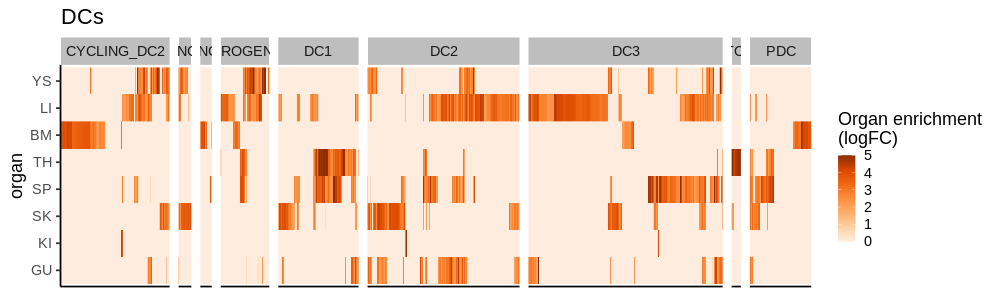

In [177]:
%%R -w 1000 -h 300
plot_organ_FC_hm_group(plot_df, "DCs", logFC_limits = c(0,5))

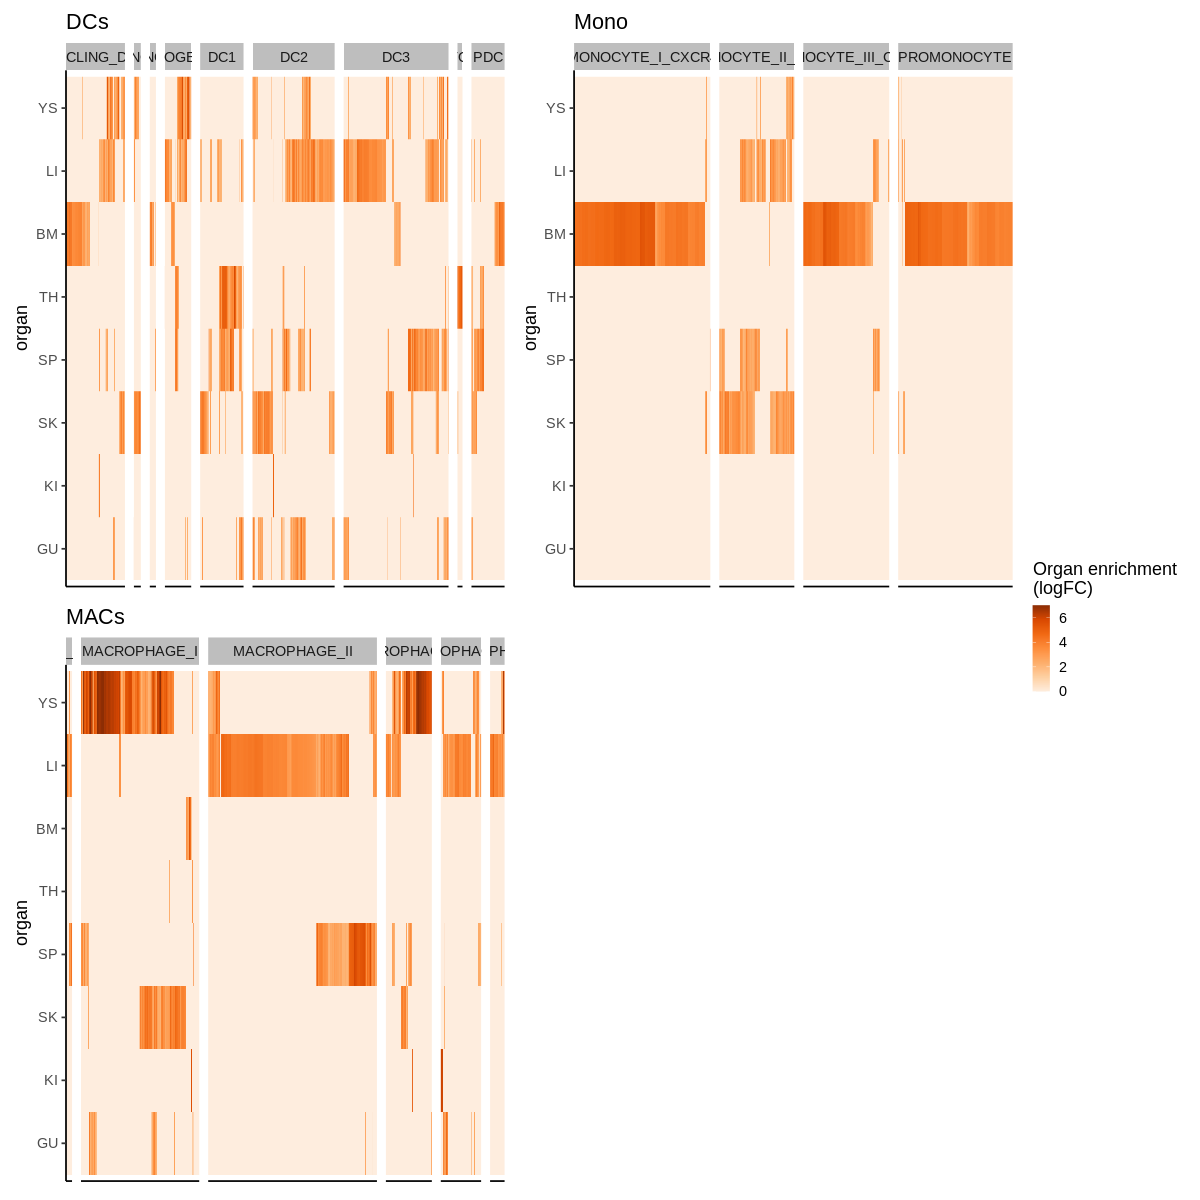

In [178]:
%%R -w 1200 -h 1200
pl_ls <- lapply(unique(plot_df$anno_group), function(g) plot_organ_FC_hm_group(plot_df, g))
wrap_plots(pl_ls[1:3], ncol=2, nrow=2) +
    plot_layout(guides='collect') +
    ggsave(paste0(figdir, 'enrichment_hm_all.pdf'), width=20, height=7) +
    ggsave(paste0(figdir, 'enrichment_hm_all.png'), width=20, height=7)

### Save outputs

In [267]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_organ_outs/{s}/'.format(s=split)
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Save dataframe for beeswarm plot
plot_df.to_csv(outdir + "milo_heatmap_plot_data.{s}.csv".format(s=split))

In [268]:
## Save processed anndata object
nhood_adata = adata.uns["nhood_adata"].copy()
del adata.uns["nhood_adata"]
adata.write_h5ad(outdir + "adata4milo_organ.{s}.h5ad".format(s=split))
adata.uns["nhood_adata"] = nhood_adata.copy()

nhood_adata.uns["annotation_labels"] = nhood_adata.uns["annotation_labels"].tolist()
nhood_adata.write_h5ad(outdir + "milo_organ_nhood_adata.{s}.h5ad".format(s=split))

... storing 'nhood_annotation' as categorical


In [12]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_organ_outs/{s}/'.format(s=split)

### Fig 2 plot

In [13]:
adata = sc.read_h5ad(outdir + "adata4milo_organ.{s}.h5ad".format(s=split))

In [14]:
nhood_adata = sc.read_h5ad(outdir + "milo_organ_nhood_adata.{s}.h5ad".format(s=split))

adata.uns["nhood_adata"] = nhood_adata.copy()

In [15]:
long_org_fc = pd.read_csv(outdir + "milo_heatmap_plot_data.{s}.csv".format(s=split), index_col=0)

In [16]:
## Update annotation
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
adata = adata[adata.obs_names.isin(anno_obs.index)].copy()
adata.obs["anno_lvl_2_final_clean"] = anno_obs.loc[adata.obs_names]["anno_lvl_2_final_clean"]

In [17]:
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")

In [18]:
nhood_adata = adata.uns["nhood_adata"].copy()
nhood_adata.obs['Nhood'] = [x+1 for x in nhood_adata.obs_names.astype("int")]
plot_nhood_df = nhood_adata.obs[['nhood_annotation_frac', "nhood_annotation", "Nhood", "Nhood_size"]]
graph_df = pd.DataFrame(nhood_adata.obsm['X_milo_graph'])
graph_df.columns = ['milo_graph_X', 'milo_graph_Y']
graph_df.index = nhood_adata.obs_names
plot_nhood_df = pd.concat([plot_nhood_df, graph_df], 1)
plot_nhood_df = pd.merge(plot_nhood_df, long_org_fc)

In [19]:
%%R -i plot_nhood_df
head(plot_nhood_df)

  nhood_annotation_frac nhood_annotation Nhood Nhood_size milo_graph_X
0             0.9253731              DC2     1        134    0.9943937
1             0.9253731              DC2     1        134    0.9943937
2             0.9253731              DC2     1        134    0.9943937
3             0.9253731              DC2     1        134    0.9943937
4             0.9253731              DC2     1        134    0.9943937
5             0.9253731              DC2     1        134    0.9943937
  milo_graph_Y nhood_anno anno_group hclust_order organ    logFC   SpatialFDR
0     9.917207        DC2        DCs           18    SK 3.942670 1.746849e-05
1     9.917207        DC2        DCs           18    SP 0.000000 1.386090e-03
2     9.917207        DC2        DCs           18    YS 0.000000 8.754517e-02
3     9.917207        DC2        DCs           18    LI 0.000000 1.000000e+00
4     9.917207        DC2        DCs           18    TH 0.000000 9.930066e-02
5     9.917207        DC2        DC

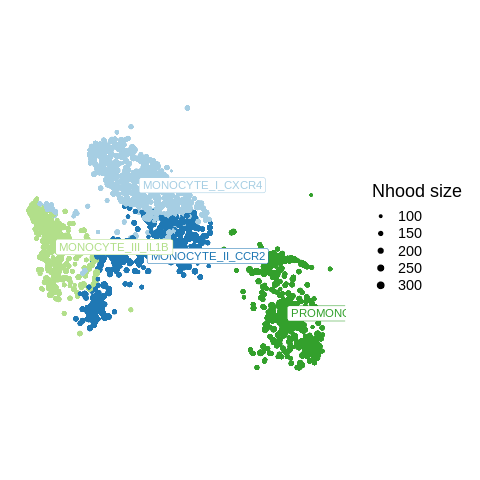

In [179]:
%%R -i figdir
cts_oi = c("MONOCYTE_I_CXCR4", "PROMONOCYTE", "MONOCYTE_II_CCR2", "MONOCYTE_III_IL1B")
organs_oi <- c("BM", "SP", "SK", "LI")
p_anno <- plot_nhood_df %>%
    filter(nhood_annotation %in% cts_oi) %>%
    filter(nhood_annotation_frac > 0.5) %>%
    ggplot(aes(milo_graph_X, milo_graph_Y, color=nhood_annotation, size=Nhood_size)) +
    geom_point_rast() +
    geom_label(data = . %>% group_by(nhood_annotation) %>% summarise(milo_graph_X = mean(milo_graph_X),milo_graph_Y = mean(milo_graph_Y)),
               aes(label=nhood_annotation), size=4, hjust=0, fill='white') +
    theme_classic(base_size=18) +
    remove_y_axis() +
    remove_x_axis() +
    guides(color='none', fill='none') +
    scale_color_brewer(palette="Paired") +
    scale_size(name="Nhood size", range=c(0.2,3)) +
    theme(axis.line=element_blank()) +
    coord_fixed()
p_anno

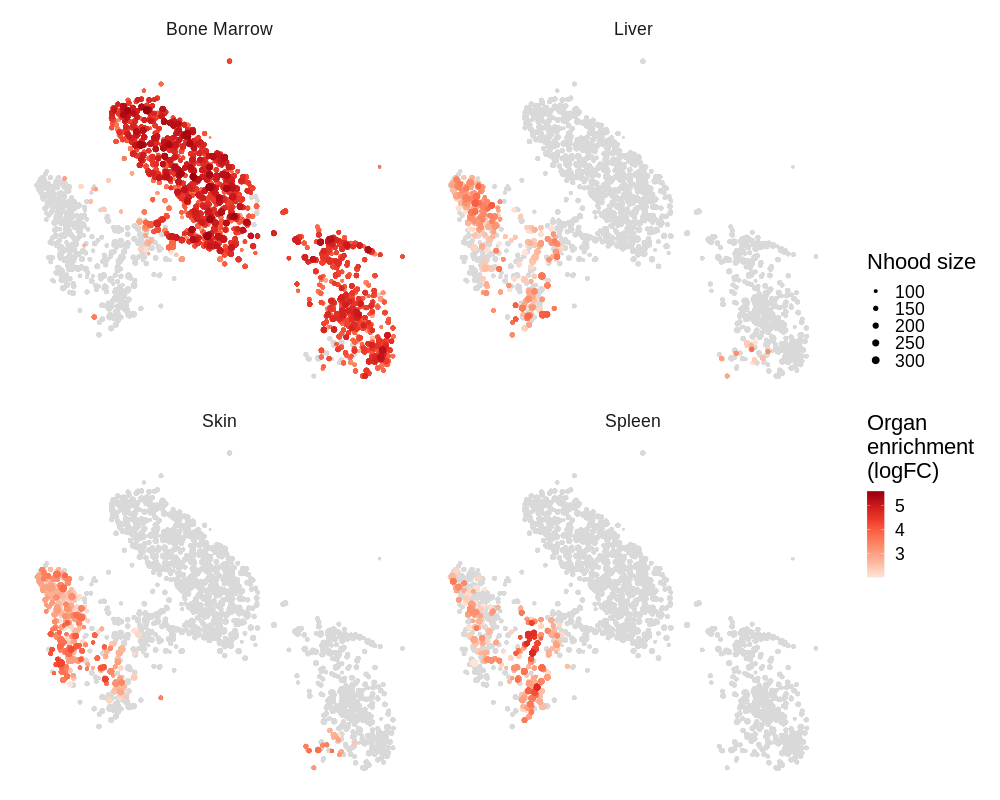

In [180]:
%%R -w 1000 -h 800
org_labels <- list(
    "SP"="Spleen",
    "LI"="Liver",
    "BM"="Bone Marrow",
    "SK" = 'Skin'
    )

org_labeller <- function(variable, value){
    return(org_labels[value])
}

pl2 <- plot_nhood_df %>%
    filter(nhood_annotation %in% cts_oi) %>%
    filter(nhood_annotation_frac > 0.5) %>%
    filter(organ %in% organs_oi) %>%
    mutate(logFC = ifelse(SpatialFDR > 0.1 | logFC == 0, NA, logFC)) %>%
    ggplot(aes(milo_graph_X, milo_graph_Y, color=logFC, size=Nhood_size)) +
    geom_point_rast(color='grey85') +
    geom_point_rast(data= . %>% filter(!is.na(logFC)) %>% arrange(logFC)) +
    facet_wrap(organ~., labeller=org_labeller) +
    theme_classic(base_size=22) +
    remove_y_axis() +
    remove_x_axis() +
    scale_color_distiller(palette="Reds", direction=1, name="Organ\nenrichment\n(logFC)") +
    scale_size(name="Nhood size", range=c(0.2,3)) +
    theme(axis.line=element_blank(), strip.background=element_rect(color=NA)) +
    coord_fixed()
    
pl2 

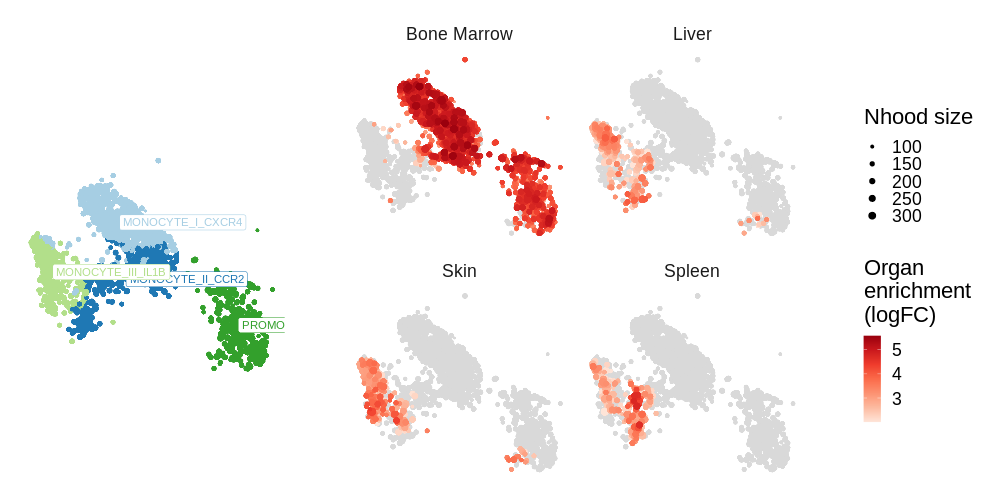

In [181]:
%%R -w 1000 -h 500
library(patchwork)
(p_anno + guides(size='none') + pl2 ) + plot_layout(widths=c(1,2), guides='collect') +
    ggsave(paste0(figdir, 'mono_figure_full.pdf'), width=16, height=8) +
    ggsave(paste0(figdir, 'mono_figure_full.png'), width=16, height=8)

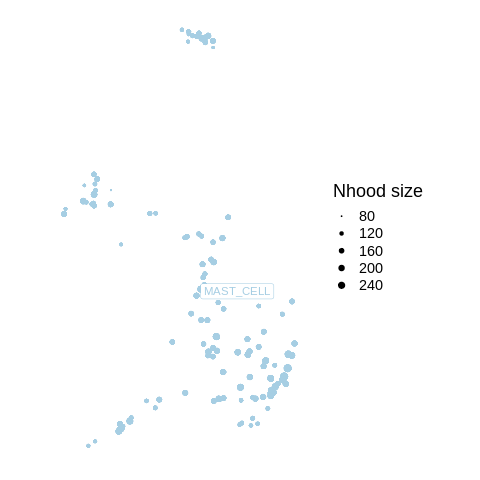

In [30]:
%%R -i figdir
library(ggrastr)
cts_oi = c("MAST_CELL")
organs_oi <- c("BM", "SP", "SK", "LI", "YS")
p_anno <- plot_nhood_df %>%
    filter(nhood_annotation %in% cts_oi) %>%
    filter(nhood_annotation_frac > 0.8) %>%
    ggplot(aes(milo_graph_X, milo_graph_Y, color=nhood_annotation, size=Nhood_size)) +
    geom_point_rast() +
    geom_label(data = . %>% group_by(nhood_annotation) %>% summarise(milo_graph_X = mean(milo_graph_X),milo_graph_Y = mean(milo_graph_Y)),
               aes(label=nhood_annotation), size=4, hjust=0, fill='white') +
    theme_classic(base_size=18) +
    remove_y_axis() +
    remove_x_axis() +
    guides(color='none', fill='none') +
    scale_color_brewer(palette="Paired") +
    scale_size(name="Nhood size", range=c(0.2,3)) +
    theme(axis.line=element_blank()) +
    coord_fixed()
p_anno

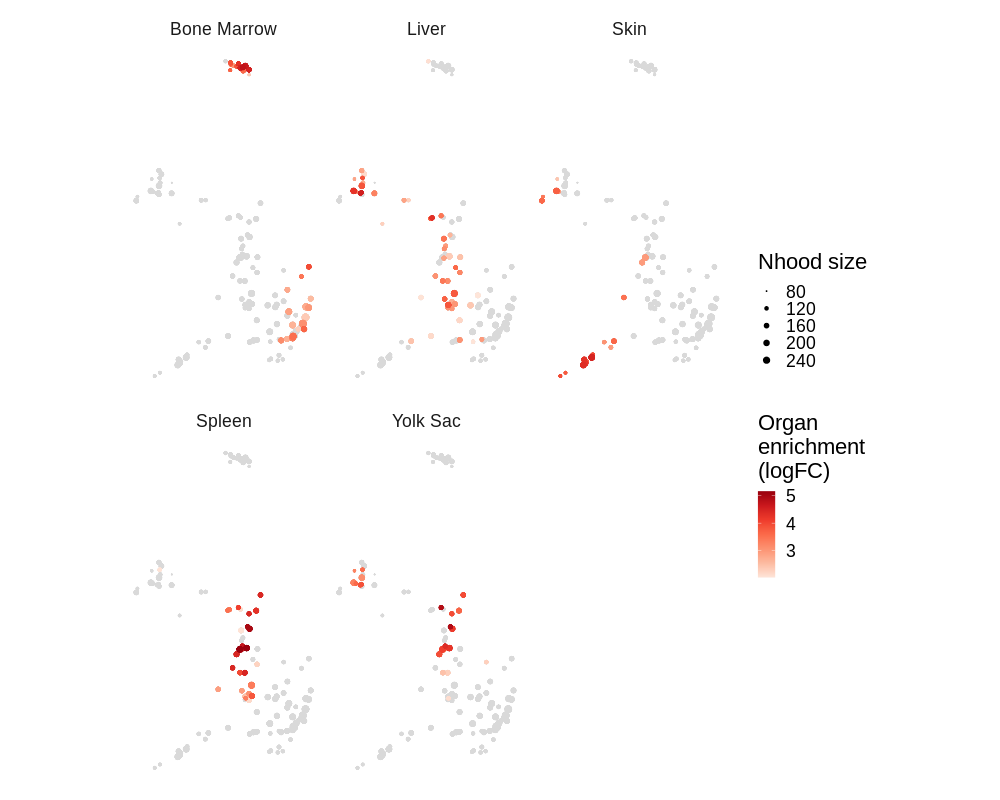

In [32]:
%%R -w 1000 -h 800
org_labels <- list(
    "SP"="Spleen",
    "LI"="Liver",
    "BM"="Bone Marrow",
    "SK" = 'Skin',
    'YS'='Yolk Sac'
    )

org_labeller <- function(variable, value){
    return(org_labels[value])
}

pl2 <- plot_nhood_df %>%
    filter(nhood_annotation %in% cts_oi) %>%
    filter(nhood_annotation_frac > 0.8) %>%
    filter(organ %in% organs_oi) %>%
    mutate(logFC = ifelse(SpatialFDR > 0.1 | logFC == 0, NA, logFC)) %>%
    ggplot(aes(milo_graph_X, milo_graph_Y, color=logFC, size=Nhood_size)) +
    geom_point_rast(color='grey85') +
    geom_point_rast(data= . %>% filter(!is.na(logFC)) %>% arrange(logFC)) +
    facet_wrap(organ~., labeller=org_labeller) +
    theme_classic(base_size=22) +
    remove_y_axis() +
    remove_x_axis() +
    scale_color_distiller(palette="Reds", direction=1, name="Organ\nenrichment\n(logFC)") +
    scale_size(name="Nhood size", range=c(0.2,3)) +
    theme(axis.line=element_blank(), strip.background=element_rect(color=NA)) +
    coord_fixed()
    
pl2 

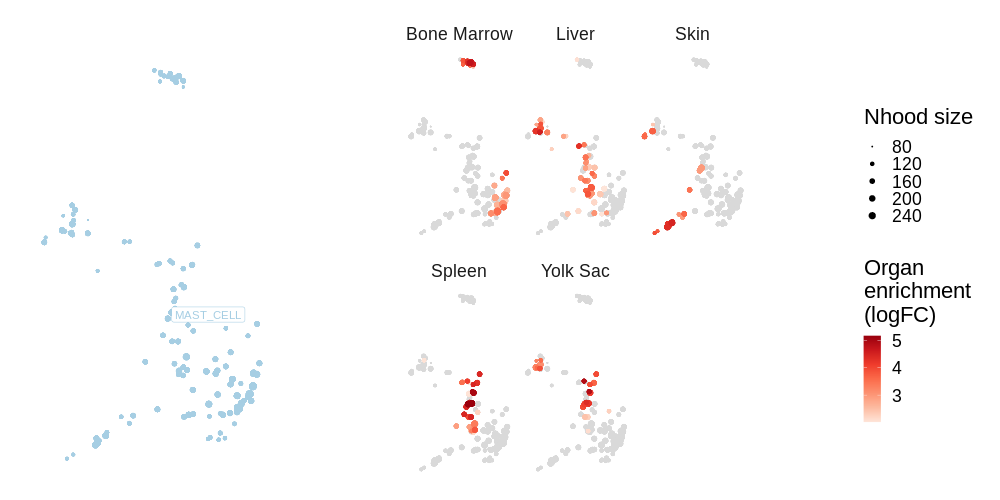

In [33]:
%%R -w 1000 -h 500
library(patchwork)
(p_anno + guides(size='none') + pl2 ) + plot_layout(widths=c(1,2), guides='collect') +
    ggsave(paste0(figdir, 'mast_figure_full.pdf'), width=16, height=8) +
    ggsave(paste0(figdir, 'mast_figure_full.png'), width=16, height=8)

In [183]:
# %%R -w 1000 -h 1000
# library(ggrastr)
# plot_nhood_df %>%
#     mutate(highlight=ifelse(nhood_annotation %in% cts_oi, "yes", NA)) %>%
#    ggplot(aes(milo_graph_X, milo_graph_Y, size=Nhood_size)) +
#     geom_point_rast(color='grey') +
#     geom_point_rast(data=. %>% filter(!is.na(highlight)), color='black') +
#     coord_fixed() +
#     cowplot::theme_nothing() +
#     scale_size(range=c(0.2,3)) +
#     ggsave(paste0(figdir, 'milo_graph_lovation.pdf'), width=6, height=6) +
#     ggsave(paste0(figdir, 'milo_graph_lovation.png'), width=6, height=6)

### Plot psuedobulk expression

In [189]:
input_dir = '/nfs/team205/ed6/data/Fetal_immune/LMM_data/DE_input_HSC_IMMUNE_PBULK/'
pbulk_adata = sc.read_mtx(input_dir + 'matrix.mtx.gz')

In [196]:
var = pd.read_csv(input_dir+'gene.csv.gz', index_col=0)
obs = pd.read_csv(input_dir+'metadata.csv.gz', index_col=0)
pbulk_adata.obs = obs.copy()
pbulk_adata.var = var.copy()
pbulk_adata

AnnData object with n_obs × n_vars = 4017 × 33538
    obs: 'Sample', 'donor', 'organ', 'anno_lvl_2_final_clean', 'age', 'method', 'n_cells'
    var: 'GeneID', 'GeneName'

In [197]:
genes_plot = {
    
}
pbulk_adata[pbulk_adata]

AnnData object with n_obs × n_vars = 4017 × 33538
    obs: 'Sample', 'donor', 'organ', 'anno_lvl_2_final_clean', 'age', 'method', 'n_cells'
    var: 'GeneID', 'GeneName'

## GSEA plot for significant DGEs

dependencies for enrichr and plotting

In [198]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import gseapy as gp
from gseapy.plot import barplot, dotplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
names = gp.get_library_name() # default: Human

In [11]:
### load DGE results
DGE_path = '/nfs/team205/ed6/data/Fetal_immune/LMM_data/DE_input_HSC_IMMUNE_PBULK/'
dge = pd.read_csv(DGE_path+'DE_results_BM_vs_rest_TEST_MONOCYTE_III_CCR2_CTRL_NK-MID_ERY-MACROPHAGE_II.csv')
test = ["MONOCYTE_III_CCR2"]
ctrl = ["NK","MID_ERY"]

In [12]:
dge['celltype_type'] = ["condition" if x in test else "ctrl" for x in dge['test_celltype']]

In [13]:
# for positively enriched list
# find genes that adjusted pval < 0.1, lfc > 1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
is_signif_up = (dge['adj_pval']<0.1) & (dge['lfc'] > 1) & (dge['celltype_type'] == 'condition')
genes_signif_up = dge.name[is_signif_up]
genes_signif_up = genes_signif_up.value_counts().index[genes_signif_up.value_counts() >= 3]
is_signif_up_ctrl = (dge['adj_pval']<0.1) & (dge['lfc'] > 0) & (dge['celltype_type'] == 'ctrl')
genes_signif_up_ctrl = dge.name[is_signif_up_ctrl].unique()

# for negatively enriched list
# find genes that adjusted pval < 0.1, lfc < -1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
is_signif_down = (dge['adj_pval']<0.1) & (dge['lfc'] < -1) & (dge['celltype_type'] == 'condition')
genes_signif_down = dge.name[is_signif_down]
genes_signif_down = genes_signif_down.value_counts().index[genes_signif_down.value_counts() >= 3]
is_signif_down_ctrl = (dge['adj_pval']<0.1) & (dge['lfc'] < 0) & (dge['celltype_type'] == 'ctrl')
genes_signif_down_ctrl = dge.name[is_signif_down_ctrl].unique()

genes_signif = np.concatenate([genes_signif_up[~genes_signif_up.isin(genes_signif_up_ctrl)].values,
genes_signif_down[~genes_signif_down.isin(genes_signif_down_ctrl)].values])

dge['significant'] = (dge['name'].isin(genes_signif)) & (dge.celltype_type == 'condition')

In [14]:
## Save for suppl material
dge.to_csv("/home/jovyan/mount/gdrive/Pan_fetal/significant_genes/organ_comparison_DGE/DE_BM_vs_rest_TEST_MONOCYTE_III_CCR2_CTRL_NK-MID_ERY-MACROPHAGE_II.csv")

In [202]:
# find background set of genes 
background = list(set(dge['name']))

In [204]:
from collections import Counter
# for positively enriched list
# find genes that adjusted pval < 0.1, lfc > 1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
dge_sig = dge[np.array(dge['adj_pval']<0.1) & np.array(dge['lfc'] > 0)]
dge_sig_test = dge_sig[np.array(dge_sig['test_celltype'].isin(test)) & np.array(dge_sig['lfc'] > 1)]
tbl = pd.DataFrame.from_dict(Counter(dge_sig_test['name']), orient='index').reset_index()

dge_sig_ctl = dge_sig[dge_sig['test_celltype'].isin(ctrl)]
tbl_new = tbl[~(tbl['index'].isin(dge_sig_ctl['name']))]

df = tbl_new
df['lfc_mean'] = 0
for i in range(df.shape[0]):
    gene = df.iloc[i,0]
    df.iloc[i,2] = np.mean(dge_sig_test.loc[dge_sig_test['name']==gene,'lfc'])
df.to_csv('csv/DE_results_CCR2MONO_BMvsOther_compiled_poslfc.csv')

# for negatively enriched list
# find genes that adjusted pval < 0.1, lfc < -1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
dge_sig = dge[np.array(dge['adj_pval']<0.1) & np.array(dge['lfc'] < 0)]
dge_sig_test = dge_sig[np.array(dge_sig['test_celltype'].isin(test)) & np.array(dge_sig['lfc'] < -1)]
tbl = pd.DataFrame.from_dict(Counter(dge_sig_test['name']), orient='index').reset_index()

dge_sig_ctl = dge_sig[dge_sig['test_celltype'].isin(ctrl)]
tbl_new = tbl[~(tbl['index'].isin(dge_sig_ctl['name']))]

df = tbl_new
df['lfc_mean'] = 0
for i in range(df.shape[0]):
    gene = df.iloc[i,0]
    df.iloc[i,2] = np.mean(dge_sig_test.loc[dge_sig_test['name']==gene,'lfc'])
df.to_csv('csv/DE_results_CCR2MONO_BMvsOther_compiled_neglfc.csv')

In [205]:
df = pd.read_csv('csv/DE_results_CCR2MONO_BMvsOther_compiled_neglfc.csv')
gene_list = list(df['index'])

In [206]:
gene_sets=['MSigDB_Hallmark_2020']

# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 description='test_data',
                 outdir='csv/enrichr/CCR2MONO_BMvsOther_compiled_neglfc/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [207]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,7/200,0.000047,0.001703,0,0,8.124352,80.909869,IL1B;PLAUR;TRIP10;G0S2;HES1;SOD2;PNRC1
1,MSigDB_Hallmark_2020,KRAS Signaling Up,6/200,0.000385,0.006934,0,0,6.849647,53.849903,MAFB;TSPAN13;IL1B;C3AR1;PLAUR;G0S2
2,MSigDB_Hallmark_2020,Pperoxisome,4/104,0.001528,0.018340,0,0,8.705495,56.442952,ACSL1;BCL10;SOD2;DHRS3
3,MSigDB_Hallmark_2020,Inflammatory Response,5/200,0.002662,0.023961,0,0,5.615385,33.291011,IL1R1;IL1B;OSM;C3AR1;PLAUR
4,MSigDB_Hallmark_2020,Cholesterol Homeostasis,3/74,0.005275,0.037977,0,0,9.109308,47.776950,PLAUR;CPEB2;PNRC1


In [208]:
# to save your figure, make sure that ``ofname`` is not None
# ax=dotplot(enr.res2d, title='MSigDB_Hallmark_2020',cmap='RdYlBu_r',cutoff = 1,top_terms=5,figsize=(6,6),ofname=fig_path+'BMvsothersCCR2MONO_neglfc_enrichr.pdf')

In [209]:
df = pd.read_csv('csv/DE_results_CCR2MONO_BMvsOther_compiled_poslfc.csv')
gene_list = list(df['index'])

In [210]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 description='test_data',
                 outdir='csv/enrichr/CCR2MONO_BMvsOther_compiled_poslfc/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [211]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,G2-M Checkpoint,11/200,1.444966e-07,0.000002,0,0,9.015665,141.996810,CDC20;TOP2A;GINS2;CCNB2;UCK2;CENPF;DTYMK;NSD2;...
1,MSigDB_Hallmark_2020,E2F Targets,11/200,1.444966e-07,0.000002,0,0,9.015665,141.996810,CDC20;TOP2A;CCNB2;HELLS;LIG1;MCM7;UBE2T;CTPS1;...
2,MSigDB_Hallmark_2020,Pperoxisome,4/104,5.859217e-03,0.056639,0,0,5.899104,30.319860,TOP2A;PEX6;DHCR24;CTPS1
3,MSigDB_Hallmark_2020,Estrogen Response Late,5/200,1.264672e-02,0.061126,0,0,3.791594,16.570621,CDC20;TOP2A;GINS2;MYB;SLC1A4
4,MSigDB_Hallmark_2020,mTORC1 Signaling,5/200,1.264672e-02,0.061126,0,0,3.791594,16.570621,SLC1A4;DHCR24;PHGDH;RRP9;MCM2


In [212]:
# # to save your figure, make sure that ``ofname`` is not None
# ax=dotplot(enr.res2d, title='MSigDB_Hallmark_2020',cmap='RdYlBu_r',cutoff = 1,top_terms=5,figsize=(6,6),ofname=fig_path+'BMvsothersCCR2MONO_neglfc_enrichr.pdf')

## Plot significant DGEs in organ comparison 

In [367]:
plot_genes = {
    'markers' : ['RETN','CXCR4', "CCR2", "IL1B"],    
    'prolif_markers' : ['MKI67'],    
    'g2m_genes' : pd.read_table('csv/enrichr/CCR2MONO_BMvsOther_compiled_poslfc/MSigDB_Hallmark_2020.Human.enrichr.reports.txt').iloc[0,9].split(';'),
    'tnf_genes' : pd.read_table('csv/enrichr/CCR2MONO_BMvsOther_compiled_neglfc/MSigDB_Hallmark_2020.Human.enrichr.reports.txt').iloc[0,9].split(';')
        
    }

all_plot_genes = sum([v for k,v in plot_genes.items()], [])

In [368]:
gene_anno_df = pd.DataFrame([(x,k) for k,v in plot_genes.items() for x in v])
gene_anno_df.columns = ['gene', 'gene_group']
gene_anno_df.index = gene_anno_df['gene']

In [369]:
all_organs = adata.obs.organ.unique().tolist()

In [370]:
def anndata2pseudobulk(adata, group_by, agg="s", min_ncells = 10):
    '''
    Params:
    ------
    adata: the anndata object
    group_by: list of obs columns to use for aggregation
    agg: "s" for sum (if adata.X are counts), "m" for mean (if adata.X are log-counts), 'n' for n expressing
    min_ncells: minimum number of cells to keep pseudobulk sample (default=10)
    '''
    from scipy.sparse import csr_matrix
    import anndata
    if agg=="s" and "log1p" in adata.uns_keys():
        print("adata.X is in log-transformed, pseudobulking should be done on counts")
        return()
    ## Make obs for pseudobulk
    pseudobulk_obs = adata.obs[group_by].drop_duplicates()
    pseudobulk_obs = pseudobulk_obs[group_by].astype("str")
    pseudobulk_obs.index = pseudobulk_obs[group_by].agg("-".join, axis=1)
    ## Add column to obs assigning cells to pseudobulk samples
    adata.obs[group_by] = adata.obs[group_by].astype("str")
    adata.obs["pseudobulk_sample"] = adata.obs[group_by].agg("-".join, axis=1)
    ## Sum counts from same sample
    sample_dummies = pd.get_dummies(adata.obs["pseudobulk_sample"])[pseudobulk_obs.index].values
    sample_dummies = scipy.sparse.csr_matrix(sample_dummies)
    pseudobulk_X = adata.X.T.dot(sample_dummies)
    ## Check that pseudobulk profiles are the sum of all profiles in a sample
    a = np.array(adata[sample_dummies[:,0]!=0].X.sum(0)).flatten()
    b = pseudobulk_X[:,0].toarray().flatten()
    if not np.all(a == b):
        print("Error! Aggregation doesn't coincide with sum across the same sample")
        return()
    if agg=="m":
        pseudobulk_X = csr_matrix(pseudobulk_X / sample_dummies.toarray().sum(0))
    if agg=='n':
        adata.X[adata.X != 0] = 1
        pseudobulk_X = adata.X.T.dot(sample_dummies)
        ## Check that pseudobulk profiles are the sum of all profiles in a sample
        a = np.array(adata[sample_dummies[:,0]!=0].X.sum(0)).flatten()
        b = pseudobulk_X[:,0].toarray().flatten()
    ## Make new anndata object
    pseudobulk_adata = anndata.AnnData(pseudobulk_X.T, obs=pseudobulk_obs, var=adata.var)
    ## Add number of cells to obs 
    n_cells = adata.obs.groupby('pseudobulk_sample').count().iloc[:,0]
    n_cells.name = "n_cells"
    pseudobulk_adata.obs = pd.concat([pseudobulk_adata.obs, n_cells], axis=1)
    ## Filter obs by number of cells threshold
    pseudobulk_adata = pseudobulk_adata[pseudobulk_adata.obs['n_cells'] >= min_ncells]

    return(pseudobulk_adata)

In [395]:
subset_organ = all_organs
subset_anno = ["MONOCYTE_I_CXCR4", "MONOCYTE_II_CCR2", "MONOCYTE_III_IL1B"]

In [396]:
## mean expression
genes = all_plot_genes
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=['anno_lvl_2_final_clean'], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=['anno_lvl_2_final_clean'], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [397]:
%%R -i X_pl_df -i N_pl_df -i all_plot_genes -i gene_anno_df
pl_df <- left_join(
        X_pl_df %>% pivot_longer(cols=unlist(unique(all_plot_genes)), names_to="gene", values_to='mean_gex'),
        N_pl_df %>% pivot_longer(cols=unlist(unique(all_plot_genes)), names_to="gene", values_to='n_cells_gex')
        ) %>%
    left_join(gene_anno_df) %>%
    mutate(organ=ifelse(organ!="BM", "other", "BM")) %>%
    group_by(organ, age_bins, gene, gene_group) %>%
    summarise(mean_gex=mean(mean_gex), n_cells_gex=sum(n_cells_gex), n_cells=sum(n_cells)) %>%
    group_by(gene) %>%
#     mutate(mean_gex=(mean_gex - min(mean_gex))/(max(mean_gex) - min(mean_gex))) 
    mutate(mean_gex=(mean_gex - mean(mean_gex))/(sd(mean_gex))) 

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = "gene"
`summarise()` has grouped output by 'organ', 'age_bins', 'gene'. You can override using the `.groups` argument.


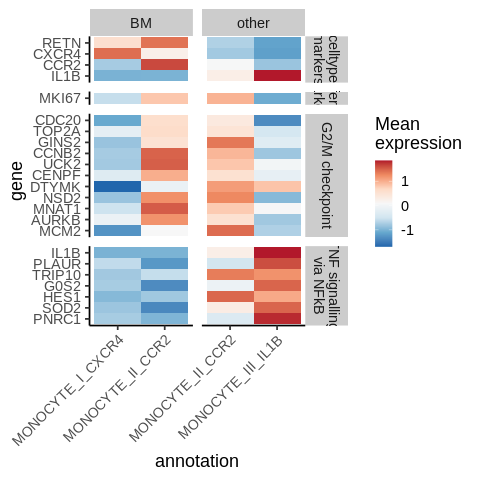

In [399]:
%%R
genesets_labels <- list(
    "markers"="celltype\nmarkers",
    'prolif_markers'='proliferation\nmarkers',
    "g2m_genes"="G2/M checkpoint",
    "tnf_genes" = 'TNF signalling\nvia NFkB'
    )

genesets_labeller <- function(variable, value){
    return(genesets_labels[value])
}

pl_df %>%
    filter(!(age_bins=="MONOCYTE_III_IL1B" & organ=="BM")) %>%
    filter(!(age_bins=="MONOCYTE_I_CXCR4" & organ=="other")) %>%
    filter(!(age_bins=="PROMONOCYTE" & organ=="other")) %>%
    mutate(gene=factor(gene, levels=rev(unlist(unique(all_plot_genes))))) %>%
    mutate(gene_group=factor(gene_group, levels=c("markers", 'prolif_markers',"g2m_genes", 'tnf_genes'))) %>%
    mutate(age_bins=factor(age_bins, levels=c("PROMONOCYTE", "MONOCYTE_I_CXCR4", "MONOCYTE_II_CCR2", "MONOCYTE_III_IL1B"))) %>%
#     mutate(gene=factor(gene, levels=l)) %>%
    ggplot(aes(age_bins, gene)) +
#     geom_point(aes(color=mean_gex, size=n_cells_gex/n_cells)) +
    geom_tile(aes(fill=mean_gex)) +
    facet_grid(gene_group~organ, scales='free', space='free', labeller=labeller(gene_group=genesets_labeller)) +
    scale_color_distiller(palette='RdBu', name='Mean\nexpression') +
    scale_fill_distiller(palette='RdBu', name='Mean\nexpression') +
    xlab("annotation") + 
    theme_classic(base_size=18) +
    scale_size(limits=c(0,1), name="Fraction\nof cells", range=c(0,5)) +
    theme( strip.background=element_rect(color=NA, fill='grey80'), axis.text.x=element_text(angle=45, vjust=1, hjust=1)) +
    ggsave(paste0(figdir, "CCR2_mono_DEGs_figure_full.pdf"), height=8, width=6)
    